In [6]:
# Load the PGN file containing the Lichess games
pgn_file = open('lichess_sseth333_games.pgn')


games = []

# Loop through each game in the PGN file
while True:
    # Read in the next game from the PGN file
    game = chess.pgn.read_game(pgn_file)
    
    if game is None:
        break
    
    # Extract the game data and append it to the list
    games.append({
        'Event': game.headers['Event'],
        'Site': game.headers['Site'],
        'Date': game.headers['Date'],
        'White': game.headers['White'],
        'Black': game.headers['Black'],
        'Result': game.headers['Result'],
        'UTCTime': game.headers['UTCTime'],
        'UTCDate': game.headers['UTCDate'],
        'WhiteElo': game.headers['WhiteElo'],
        'BlackElo': game.headers['BlackElo'],
        'Variant': game.headers['Variant'],
        'TimeControl': game.headers['TimeControl'],
        'ECO': game.headers['ECO'],
        'Termination': game.headers['Termination'],
        'Opening': game.headers['Opening'],
        'Moves': game.mainline_moves()
    })
    
    break

# Convert the list of games to a pandas DataFrame
df = pd.DataFrame(games)
df

,Event,Site,Date,White,Black,Result,UTCTime,UTCDate,WhiteElo,BlackElo,Variant,TimeControl,ECO,Termination,Opening,Moves
0,Rated Blitz game,https://lichess.org/qwx9tF5P,2023.05.04,PAASHUPATASTRA,sseth333,1-0,06:39:50,2023.05.04,2006,2018,Standard,180+0,A35,Normal,"English Opening: Symmetrical Variation, Four K...",1. c4 { [%clk 0:03:00] } 1... c5 { [%clk 0:03:...


In [9]:
import pandas as pd
import numpy as np
import chess
import chess.pgn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def create_board_state(board):
    """Convert chess board to numerical representation."""
    state = np.zeros(64 * 12, dtype=np.int8)  # 12 piece types * 64 squares
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            piece_idx = piece.piece_type - 1
            if piece.color == chess.BLACK:
                piece_idx += 6
            state[square + piece_idx * 64] = 1
    return state

def create_move_label(move):
    """Convert chess move to label."""
    return move.from_square * 64 + move.to_square

def prepare_training_data(df):
    """Prepare training data from games DataFrame."""
    X = []
    y = []
    for _, game in df.iterrows():
        board = chess.Board()
        for move in game['Moves']:
            X.append(create_board_state(board))
            y.append(create_move_label(move))
            board.push(move)
    return np.array(X), np.array(y)


# Prepare the training data
X, y = prepare_training_data(df)
y = to_categorical(y, num_classes=64 * 64)
print(X.shape, y.shape)

(91, 768) (91, 4096)


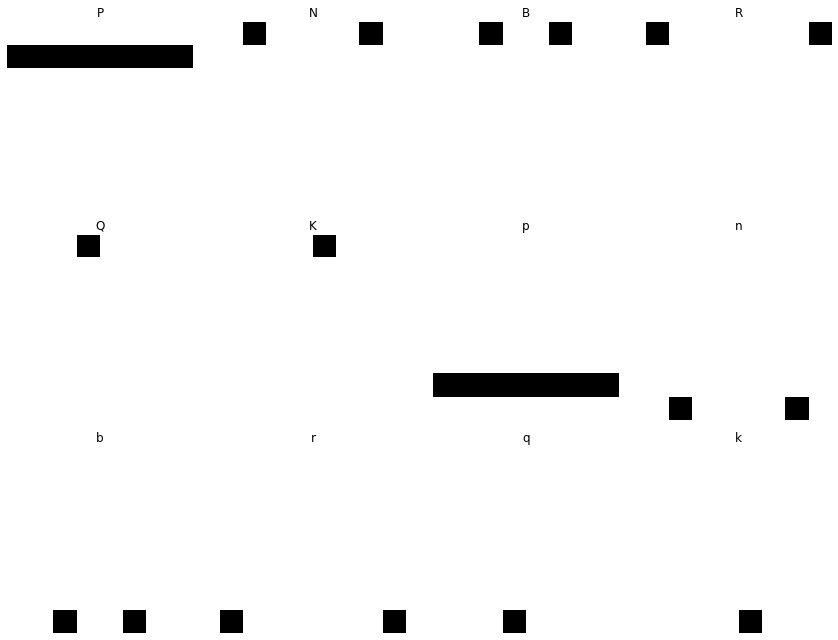

In [12]:
import numpy as np
import chess
import matplotlib.pyplot as plt

def create_board_state(board):
    state = np.zeros((12, 8, 8), dtype=np.int8)  # 12 channels for piece types
    piece_map = board.piece_map()
    for square, piece in piece_map.items():
        piece_idx = piece.piece_type - 1
        if piece.color == chess.BLACK:
            piece_idx += 6
        row, col = divmod(square, 8)
        state[piece_idx, row, col] = 1
    return state

def plot_board_state(state):
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    piece_labels = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']
    for i, ax in enumerate(axes.flat):
        ax.imshow(state[i], cmap='gray_r')
        ax.set_title(piece_labels[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
board = chess.Board()
state = create_board_state(board)
plot_board_state(state)


In [14]:
import pandas as pd
import chess.pgn

def create_move_label(move):
    return move.from_square * 64 + move.to_square

def prepare_training_data(df):
    X = []
    y = []
    for _, game in df.iterrows():
        board = chess.Board()
        for move in game['Moves']:
            X.append(create_board_state(board))
            y.append(create_move_label(move))
            board.push(move)
    return np.array(X), np.array(y)

X, y = prepare_training_data(df)

print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")

Input shape: (91, 12, 8, 8)
Output shape: (91,)


Move: c2c4


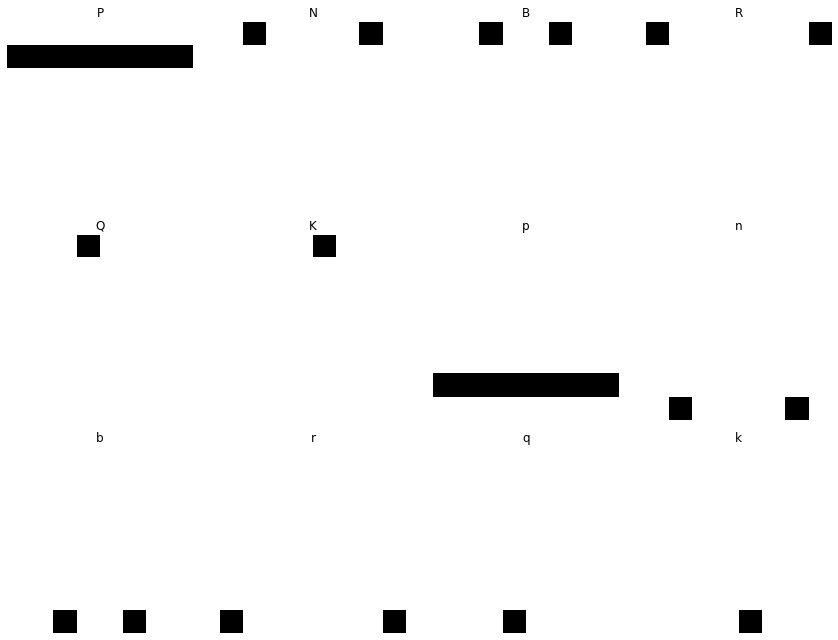

In [15]:
def plot_sample(X, y, index):
    state = X[index]
    move_label = y[index]
    move_from = move_label // 64
    move_to = move_label % 64
    move = chess.Move(move_from, move_to)

    print(f"Move: {move.uci()}")
    plot_board_state(state)

# Example usage
sample_index = 0
plot_sample(X, y, sample_index)
